**CheXpert-derived labels** were used for the following reasons:
  - Wider clinical coverage (more findings per study captured).
  - Multi-label ready (each study has 14 possible findings).
  - Includes uncertain cases (better mimics clinical reality).
  - CheXpert prioritization logic (positive > uncertain > negative) is more consistent with human diagnostic decision-making.
  - Standardized mention extraction patterns (including synonyms and abbreviations).

The following are the labels extracted using CheXpert:
- No Finding
- Enlarged Cardiomediastinum
- Cardiomegaly
- Lung Opacity                                            
- Lung Lesion
- Edema
- Consolidation
- Pneumonia
- Atelectasis
- Pneumothorax
- Pleural Effusion
- Pleural Other
- Fracture
- Support Devices


| Label Value | Meaning       | Interpretation                                    |
| ----------- | ------------- | ------------------------------------------------- |
| `1.0`       | Positive      | Condition is clearly **present**                 |
| `0.0`       | Negative      | Condition is clearly **absent**                   |
| `-1.0`      | Uncertain     | Radiologist **suspects** condition but isn't sure |
| `null`      | Not mentioned | No statement about the condition                  |


There are over 14 view positions for the chest X-rays in the dataset.

For chest X-rays, **PA (Posteroanterior)** and **AP (Anteroposterior)** are the most common and diagnostically rich frontal views:

- **PA** is the standard in ambulatory settings:
  - The patient stands facing the detector.
  - Results in a clearer and less magnified heart silhouette.

- **AP** is often used for bedridden or ICU patients:
  - Taken with the detector behind the patient.
  - More prone to artifacts, but still interpretable.

These views are preferred because:

- They provide a **full frontal projection** of the chest.
- They are **easier to learn from** due to greater dataset availability.
- They offer **more consistent anatomical display** across patients.
- They are **commonly labeled** as part of “normal” or “abnormal” classes in training datasets.

By **restricting training to PA/AP views**, we:
- **Reduce variability** caused by pose or projection differences.
- Help the model **focus on pathology**, rather than view-dependent artifacts.


## Imports

In [11]:
import pandas as pd
import gcsfs
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from collections import defaultdict

plt.style.use('default')
sns.set_palette("colorblind")

## Creating dataset

In [12]:
bucket_name = "filtered_cxr"
file_path = "cxr"
gcs_path = f"gs://{bucket_name}/{file_path}"

df = pd.read_csv(gcs_path)
df.head()

,subject_id,study_id,dicom_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,...,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices,split,ViewPosition,Rows,Columns,study_datetime
0,14887088,54257662,1bc85033-355accce-e8d0ed50-78188cd3-dac92e86,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,train,AP,2539,776,2135-01-27 04:49:44.968
1,18650767,54780106,7920918a-6b7415f5-f5b6f7d5-815bb396-c6702eb3,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,train,PA,1504,1188,2131-09-14 22:14:49.221
2,11548266,59905684,95bf2c9c-fd2e6da5-fe82e5db-032420dd-d4daa45c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,train,PA,1713,1309,2129-04-20 13:37:47.133
3,13191147,55483625,b9cf3249-939bd85e-aaf9795b-d2c0a201-3c0d322c,NaN,NaN,NaN,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,train,PA,2000,1356,2184-12-08 12:03:51.120
4,13880916,53360233,729183be-b03670e1-35db29c1-356f54ed-94481994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,train,PA,1986,1380,2170-04-27 12:42:31.124


In [13]:
df.shape

(243324, 22)

In [14]:
pathologies = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged_Cardiomediastinum", "Fracture", "Lung_Lesion", "Lung_Opacity",
    "Pleural_Effusion", "Pleural_Other", "Pneumonia", "Pneumothorax",
    "Support_Devices", "No_Finding"
]

positive_counts = {}
for pathology in pathologies:
    positive_count = (df[pathology] == 1.0).sum()
    positive_counts[pathology] = positive_count
    print(f"{pathology}: {positive_count:,} positive samples")

print(f"\nTotal unique samples in dataset: {len(df):,}")
print(f"Total positive labels across all conditions: {sum(positive_counts.values()):,}")

Atelectasis: 48,790 positive samples
Cardiomegaly: 47,673 positive samples
Consolidation: 11,525 positive samples
Edema: 29,331 positive samples
Enlarged_Cardiomediastinum: 7,657 positive samples
Fracture: 4,781 positive samples
Lung_Lesion: 6,632 positive samples
Lung_Opacity: 54,769 positive samples
Pleural_Effusion: 57,721 positive samples
Pleural_Other: 2,083 positive samples
Pneumonia: 17,222 positive samples
Pneumothorax: 11,235 positive samples
Support_Devices: 73,294 positive samples
No_Finding: 81,117 positive samples

Total unique samples in dataset: 243,324
Total positive labels across all conditions: 453,830


### Sampling images per lable

In [15]:
df["unique_id"] = df["subject_id"].astype(str) + "_" + df["study_id"].astype(str) + "_" + df["dicom_id"].astype(str)

df = shuffle(df, random_state=33)

used_keys = set()

target_counts = {
    "Atelectasis": 5000, "Cardiomegaly": 5000, "Consolidation": 5000, "Edema": 5000,
    "Enlarged_Cardiomediastinum": 5000, "Fracture": 4781, "Lung_Lesion": 5000,
    "Lung_Opacity": 5000, "Pleural_Effusion": 5000, "Pleural_Other": 2083,
    "Pneumonia": 5000, "Pneumothorax": 5000, "Support_Devices": 5000, "No_Finding": 5000
}

used_ids = set()
label_counts = defaultdict(int)
final_rows = []

df = shuffle(df, random_state=33)

for _, row in df.iterrows():
    uid = row["unique_id"]
    if uid in used_ids:
        continue

    pos_labels = [label for label in pathologies if row[label] in [1, -1]]

    for label in pos_labels:
        if label_counts[label] < target_counts[label]:
            row_dict = row.to_dict()
            final_rows.append(row_dict)
            label_counts[label] += 1
            used_ids.add(uid)
            break  

    if all(label_counts[l] >= target_counts[l] for l in target_counts):
        break

final_df = pd.DataFrame(final_rows)

print("Final dataset shape:", final_df.shape)



Final dataset shape: (66707, 23)


In [16]:
positive_counts2 = {}
for pathology in pathologies:
    positive_count = (final_df[pathology] == 1.0).sum()
    positive_counts2[pathology] = positive_count
    print(f"{pathology}: {positive_count:,} positive samples")

print(f"\nTotal unique samples in dataset: {len(final_df['unique_id']):,}")
len(final_df)

Atelectasis: 16,310 positive samples
Cardiomegaly: 15,092 positive samples
Consolidation: 5,077 positive samples
Edema: 9,711 positive samples
Enlarged_Cardiomediastinum: 3,766 positive samples
Fracture: 4,732 positive samples
Lung_Lesion: 5,228 positive samples
Lung_Opacity: 21,282 positive samples
Pleural_Effusion: 21,206 positive samples
Pleural_Other: 2,083 positive samples
Pneumonia: 7,281 positive samples
Pneumothorax: 7,282 positive samples
Support_Devices: 26,640 positive samples
No_Finding: 8,026 positive samples

Total unique samples in dataset: 66,707


66707

### Adding a mini-report

In [17]:
def label_to_text(label, condition):
    if pd.isna(label):
        return None
    elif condition == 'No_Finding':
        # Special handling for No_Finding
        if label == 1.0:
            return "The chest X-ray appears normal with no acute findings."
        elif label == 0.0:
            return "Abnormal findings are present."  # If No_Finding is explicitly negative
        elif label == -1.0:
            return "The image quality or findings are uncertain."
        else:
            return None
    else:
        # Handle pathological conditions
        if label == 1.0:
            return f"Evidence of {condition.lower().replace('_', ' ')} is present."
        elif label == 0.0:
            return f"No evidence of {condition.lower().replace('_', ' ')}."
        elif label == -1.0:
            return f"There is suspicion of {condition.lower().replace('_', ' ')}."
        else:
            return None

def create_report(row):
    sentences = []
    
    # Check if this is a normal case (No_Finding = 1.0 and no positive pathological findings)
    is_normal = (row['No_Finding'] == 1.0 and 
                 (row[pathologies] != 1.0).all())
    
    if is_normal:
        # For normal cases, just use the No_Finding description
        normal_sentence = label_to_text(row['No_Finding'], 'No_Finding')
        if normal_sentence:
            sentences.append(normal_sentence)
    else:
        # For abnormal cases, describe all findings except No_Finding
        for condition in pathologies:
            sentence = label_to_text(row[condition], condition)
            if sentence:
                sentences.append(sentence)
        
        # Only mention No_Finding if it's explicitly negative (meaning abnormal)
        if row['No_Finding'] == 0.0:
            no_finding_sentence = label_to_text(row['No_Finding'], 'No_Finding')
            if no_finding_sentence:
                sentences.insert(0, no_finding_sentence)  # Put at beginning
    
    return " ".join(sentences)

# Add new column to the DataFrame
final_df["mini_report"] = final_df.apply(create_report, axis=1)

# Save final result
final_df.to_csv('../data/sampled_5000_per_label.csv', index=False)

print(f"\nFinal dataset: {len(final_df)} samples")
print(f"Normal cases (No_Finding=1.0): {len(final_df[final_df['No_Finding'] == 1.0])}")
print(f"Abnormal cases: {len(final_df[final_df['No_Finding'] != 1.0])}")


Final dataset: 66707 samples
Normal cases (No_Finding=1.0): 8026
Abnormal cases: 58681


### Creating train, test and val splits

In [19]:
# Replace NaN with 0 for stratification purposes
stratify_labels = final_df[pathologies].fillna(0).values

print(f"Original dataset shape: {final_df.shape}")
print(f"Stratification labels shape: {stratify_labels.shape}")

# First split: separate out test set (20%)
splitter_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=33)
train_val_idx, test_idx = next(splitter_test.split(final_df, stratify_labels))

train_val_df = final_df.iloc[train_val_idx].copy()
test_df = final_df.iloc[test_idx].copy()
train_val_labels = stratify_labels[train_val_idx]

print(f"Train+Val set shape: {train_val_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Second split: split train+val into train (60% of original) and val (20% of original)
# This means val will be 0.25 of the train_val set (0.25 * 0.8 = 0.2 of original)
splitter_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=33)
train_idx, val_idx = next(splitter_val.split(train_val_df, train_val_labels))

train_df = train_val_df.iloc[train_idx].copy()
val_df = train_val_df.iloc[val_idx].copy()

print(f"\nFinal split sizes:")
print(f"Train set: {train_df.shape[0]} samples ({train_df.shape[0]/len(final_df)*100:.1f}%)")
print(f"Val set: {val_df.shape[0]} samples ({val_df.shape[0]/len(final_df)*100:.1f}%)")
print(f"Test set: {test_df.shape[0]} samples ({test_df.shape[0]/len(final_df)*100:.1f}%)")

# Save the splits
train_df.to_csv('../data/train_split.csv', index=False)
val_df.to_csv('../data/val_split.csv', index=False)
test_df.to_csv('../data/test_split.csv', index=False)

print(f"\nSaved splits to CSV files:")
print(f"- train_split.csv: {len(train_df)} samples")
print(f"- val_split.csv: {len(val_df)} samples") 
print(f"- test_split.csv: {len(test_df)} samples")

Original dataset shape: (66707, 24)
Stratification labels shape: (66707, 14)
Train+Val set shape: (53275, 24)
Test set shape: (13432, 24)

Final split sizes:
Train set: 39963 samples (59.9%)
Val set: 13312 samples (20.0%)
Test set: 13432 samples (20.1%)

Saved splits to CSV files:
- train_split.csv: 39963 samples
- val_split.csv: 13312 samples
- test_split.csv: 13432 samples


### Visualizing distribution of pathologies across splits

In [20]:
distribution_data = []
    
datasets = {
    'Train': train_df,
    'Validation': val_df, 
    'Test': test_df
}

for split_name, df in datasets.items():
    for pathology in pathologies:
        positive_count = (df[pathology] == 1.0).sum()
        total_count = df[pathology].notna().sum()
        percentage = (positive_count / total_count * 100) if total_count > 0 else 0
        
        distribution_data.append({
            'Split': split_name,
            'Pathology': pathology,
            'Positive_Count': positive_count,
            'Total_Count': total_count,
            'Percentage': percentage
        })

distribution_df = pd.DataFrame(distribution_data)

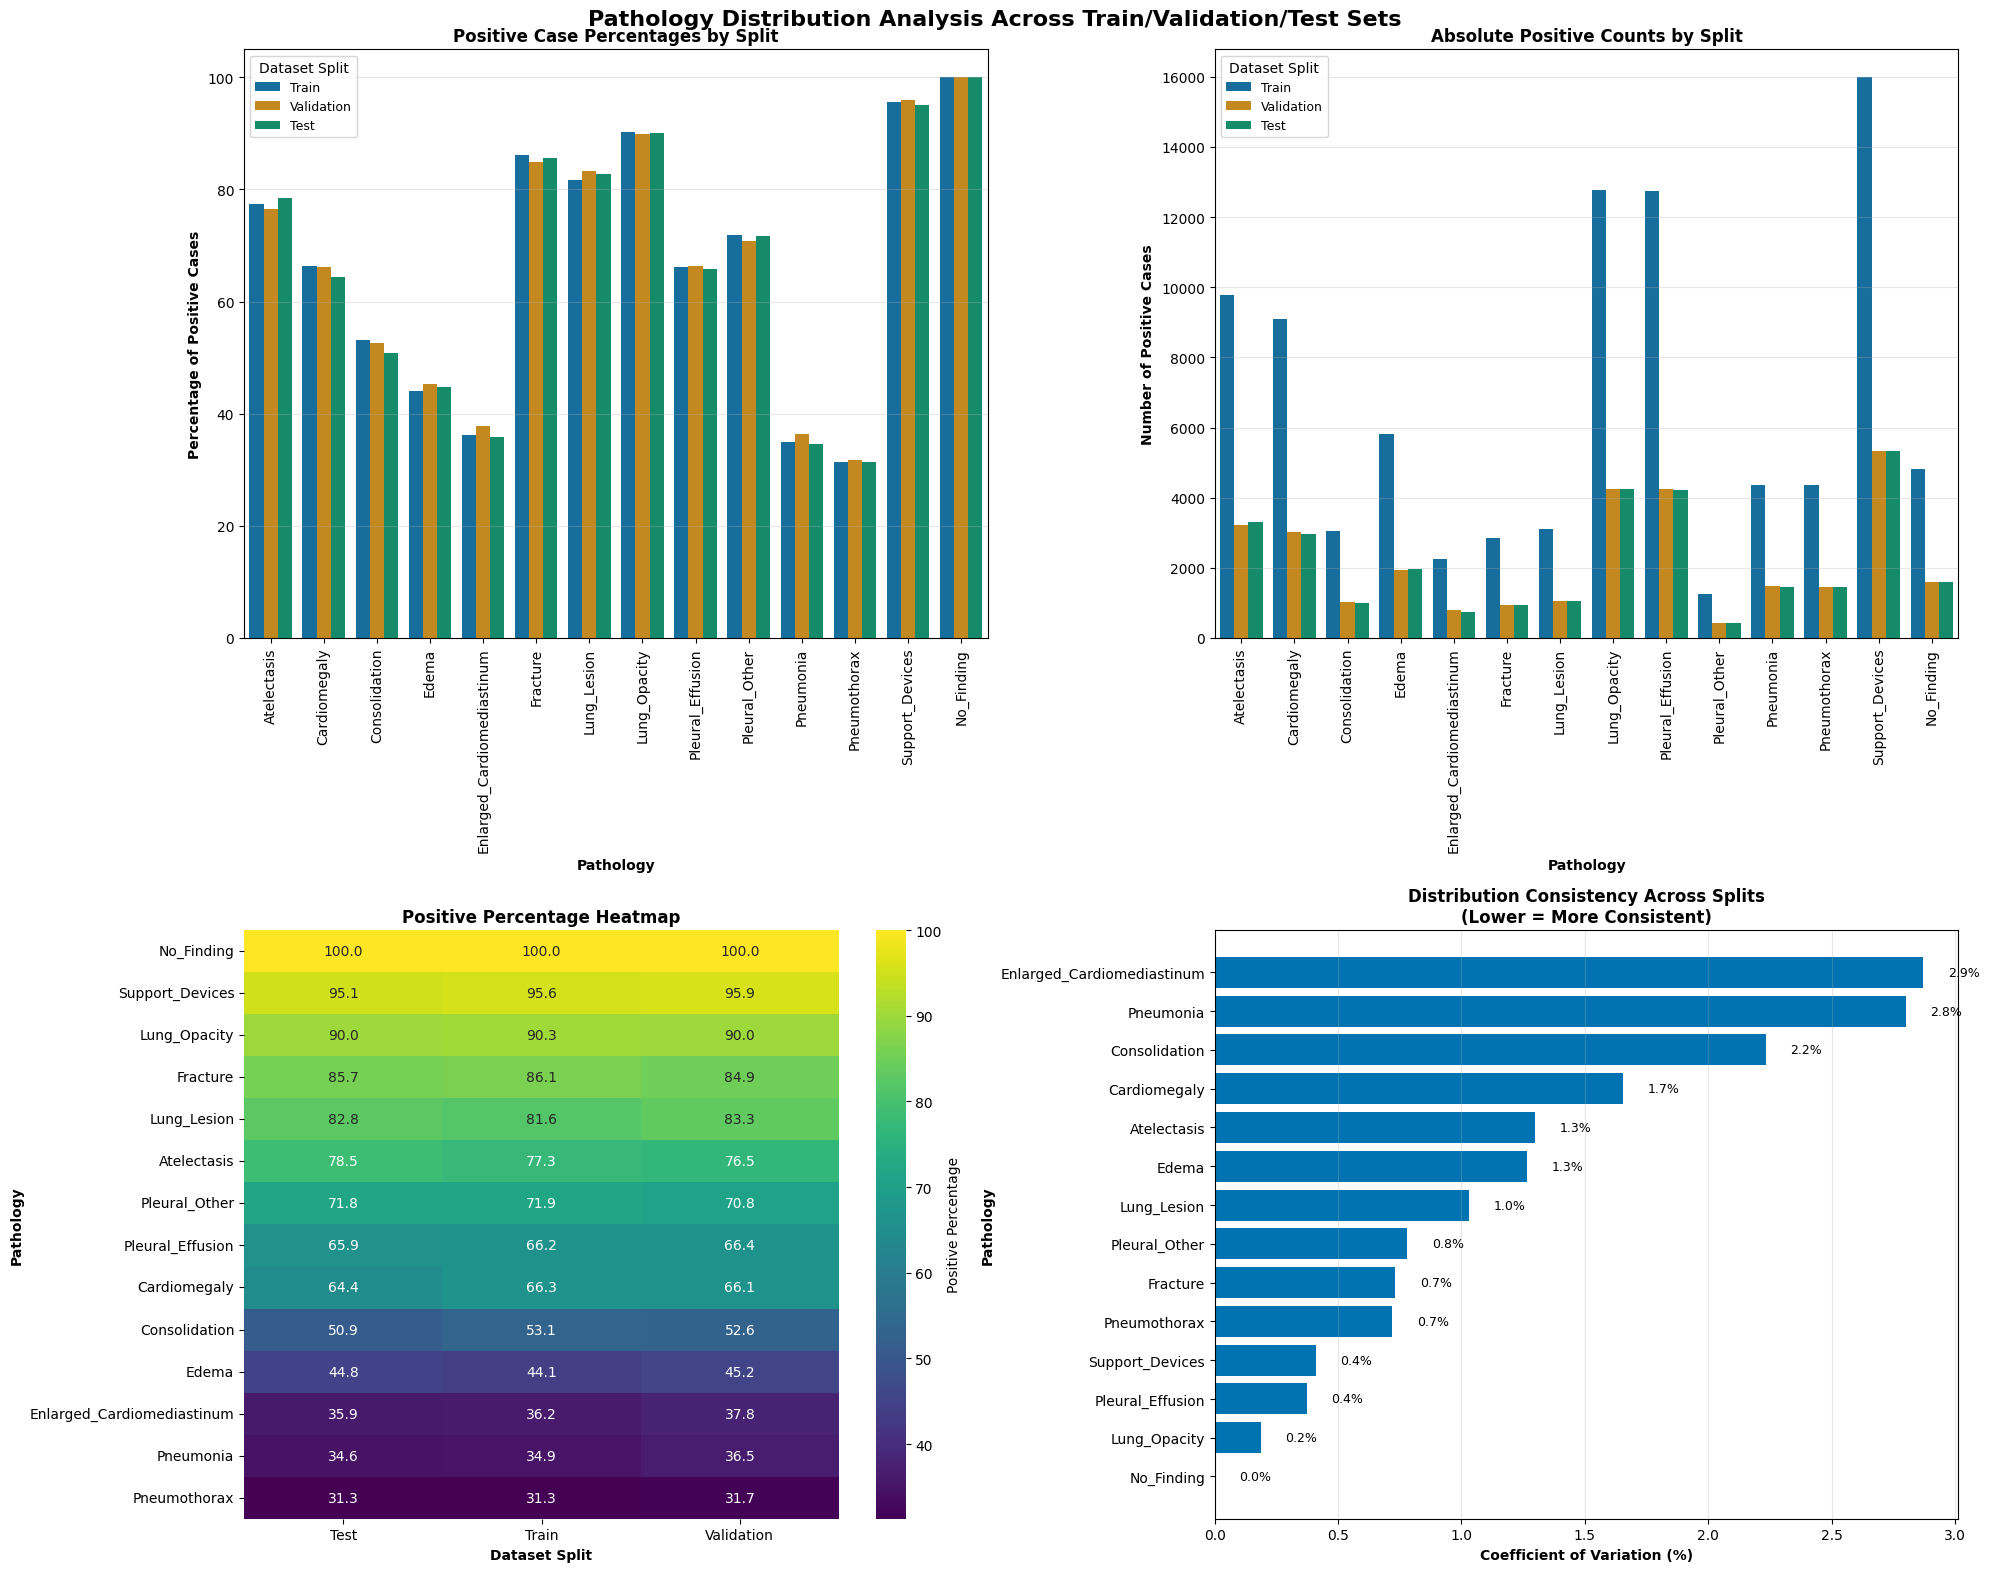

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Pathology Distribution Analysis Across Train/Validation/Test Sets', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
pivot_pct = distribution_df.pivot(index='Pathology', columns='Split', values='Percentage')
pivot_pct = pivot_pct.reindex(pivot_pct.mean(axis=1).sort_values(ascending=False).index)

sns.barplot(data=distribution_df, x='Pathology', y='Percentage', hue='Split', ax=ax1, palette='colorblind')
ax1.set_title('Positive Case Percentages by Split', fontweight='bold', fontsize=12)
ax1.set_xlabel('Pathology', fontweight='bold')
ax1.set_ylabel('Percentage of Positive Cases', fontweight='bold')
ax1.tick_params(axis='x', rotation=90)
ax1.legend(title='Dataset Split', title_fontsize=10, fontsize=9)
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
sns.barplot(data=distribution_df, x='Pathology', y='Positive_Count', hue='Split', ax=ax2, palette='colorblind')
ax2.set_title('Absolute Positive Counts by Split', fontweight='bold', fontsize=12)
ax2.set_xlabel('Pathology', fontweight='bold')
ax2.set_ylabel('Number of Positive Cases', fontweight='bold')
ax2.tick_params(axis='x', rotation=90)
ax2.legend(title='Dataset Split', title_fontsize=10, fontsize=9)
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
heatmap_data = distribution_df.pivot(index='Pathology', columns='Split', values='Percentage')
heatmap_data = heatmap_data.reindex(heatmap_data.mean(axis=1).sort_values(ascending=False).index)

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='viridis', ax=ax3, 
            cbar_kws={'label': 'Positive Percentage'})
ax3.set_title('Positive Percentage Heatmap', fontweight='bold', fontsize=12)
ax3.set_xlabel('Dataset Split', fontweight='bold')
ax3.set_ylabel('Pathology', fontweight='bold')


ax4 = axes[1, 1]
consistency_data = []
for pathology in pathologies:
    pathology_data = distribution_df[distribution_df['Pathology'] == pathology]['Percentage']
    cv = pathology_data.std() / pathology_data.mean() * 100 if pathology_data.mean() > 0 else 0
    consistency_data.append({'Pathology': pathology, 'CV': cv})

consistency_df = pd.DataFrame(consistency_data).sort_values('CV', ascending=True)

bars = ax4.barh(consistency_df['Pathology'], consistency_df['CV'], color=sns.color_palette('colorblind')[0])
ax4.set_title('Distribution Consistency Across Splits\n(Lower = More Consistent)', fontweight='bold', fontsize=12)
ax4.set_xlabel('Coefficient of Variation (%)', fontweight='bold')
ax4.set_ylabel('Pathology', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

for bar, cv in zip(bars, consistency_df['CV']):
    ax4.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{cv:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Distribution Statistics 

In [22]:
print("How many positive samples of each pathology exist in each split?")
pivot_counts = distribution_df.pivot(index='Pathology', columns='Split', values='Positive_Count')
pivot_counts = pivot_counts.reindex(pivot_counts.sum(axis=1).sort_values(ascending=False).index)
print(pivot_counts.to_string())

print("\nWhat percentage of each class's total positive samples are in each split?")
pivot_percentages = distribution_df.pivot(index='Pathology', columns='Split', values='Percentage')
pivot_percentages = pivot_percentages.reindex(pivot_percentages.mean(axis=1).sort_values(ascending=False).index)
print(pivot_percentages.round(1).to_string())

print("\nCONSISTENCY ANALYSIS:")
print("(Coefficient of Variation - lower values indicate more consistent distribution)")
for _, row in consistency_df.iterrows():
    status = "Excellent" if row['CV'] < 2 else "Moderate" if row['CV'] < 5 else "Poor"
    print(f"{row['Pathology']:<25}: {row['CV']:>5.1f}% {status}")

# Summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"• Total samples across all splits: {distribution_df.groupby('Split')['Total_Count'].first().sum():,}")
print(f"• Most common pathology: {pivot_percentages.mean(axis=1).idxmax()} ({pivot_percentages.mean(axis=1).max():.1f}% avg)")
print(f"• Least common pathology: {pivot_percentages.mean(axis=1).idxmin()} ({pivot_percentages.mean(axis=1).min():.1f}% avg)")
print(f"• Best consistency: {consistency_df.iloc[0]['Pathology']} (CV: {consistency_df.iloc[0]['CV']:.1f}%)")
print(f"• Worst consistency: {consistency_df.iloc[-1]['Pathology']} (CV: {consistency_df.iloc[-1]['CV']:.1f}%)")

How many positive samples of each pathology exist in each split?
Split                       Test  Train  Validation
Pathology                                          
Support_Devices             5326  15983        5331
Lung_Opacity                4258  12773        4251
Pleural_Effusion            4209  12743        4254
Atelectasis                 3300   9788        3222
Cardiomegaly                2968   9106        3018
Edema                       1962   5806        1943
No_Finding                  1605   4816        1605
Pneumothorax                1455   4370        1457
Pneumonia                   1443   4351        1487
Lung_Lesion                 1052   3119        1057
Consolidation                994   3048        1035
Fracture                     952   2842         938
Enlarged_Cardiomediastinum   742   2239         785
Pleural_Other                414   1256         413

What percentage of each class's total positive samples are in each split?
Split                       